In [126]:
# increase windows size
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [127]:
# set notebook max rows view
pd.set_option('display.max_rows', 500)

In [128]:
# configs
import warnings
warnings.filterwarnings("ignore")

In [129]:
# read csvs & build dataframe
import pandas as pd
df = pd.read_csv('dataset.csv')

In [130]:
################################################ pre processing of the dataset
def get_trimestres_indicadores(series, indicator, period):
    val = []
    trimestres_template = df.groupby(pd.to_datetime(df['DATA']).dt.to_period(period))['VENDAS'].agg(indicator)
    for i in range(len(series)):
        val.append(trimestres_template[series[i]].astype(int))
    return val

def set_vendas_ontem(df):
    df_temp = df['VENDAS'].shift(1)
    df_temp[0:1] = df[0:1]['VENDAS']
    return df_temp

df.insert(loc=20, column='VENDAS_MEDIA_TRIM', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('Q').astype(str), 'mean', 'Q')))
df.insert(loc=21, column='VENDAS_MEDIA_MES', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('M').astype(str), 'mean', 'M')))
df.insert(loc=22, column='VENDAS_STD_TRIM', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('Q').astype(str), 'std', 'Q')))
df.insert(loc=23, column='VENDAS_STD_MES', value=(get_trimestres_indicadores(pd.to_datetime(df['DATA']).dt.to_period('M').astype(str), 'std', 'M')))
df.insert(loc=24, column='VENDAS_ONTEM', value=(set_vendas_ontem(df)))

df['DATA'] = (pd.to_datetime(df['DATA'], dayfirst=True))

In [131]:
################################################ removing outliers (lower then 3% of occurencies)
df = df.query('VENDAS < 200 and VENDAS > 70')
df = df.query('FECHADO == 0 and ABERTO == 1')

In [132]:
################################################ dropping columns (columns ambiguity)
df = df.drop(columns=['FECHADO', 'ABERTO', 'DS', 'DATA_NAO_FESTIVA', 'BAIXA_TEMPORADA', 'SEMANA_DE_NAO_PAGAMENTO', 'NAO_FERIADO'])

In [133]:
################################################ Basic EDA
print(f'Does the Dataset has null values?: {df.isnull().values.any()}')
print(f'Does the Dataset has N/A values?: {df.isna().values.any()}')
print(f'What is the dataset format?: {df.shape}')
df.info()

Does the Dataset has null values?: False
Does the Dataset has N/A values?: False
What is the dataset format?: (715, 18)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 715 entries, 0 to 751
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   DATA                  715 non-null    datetime64[ns]
 1   VENDAS                715 non-null    int64         
 2   FDS                   715 non-null    int64         
 3   DATA_FESTIVA          715 non-null    int64         
 4   VESPERA_DATA_FESTIVA  715 non-null    int64         
 5   POS_DATA_FESTIVA      715 non-null    int64         
 6   FERIADO               715 non-null    int64         
 7   SEMANA_PAGAMENTO      715 non-null    int64         
 8   ALTA_TEMPORADA        715 non-null    int64         
 9   QTD_CONCORRENTES      715 non-null    int64         
 10  PRECIPITACAO          715 non-null    int64         
 11  TEMPERATURA     

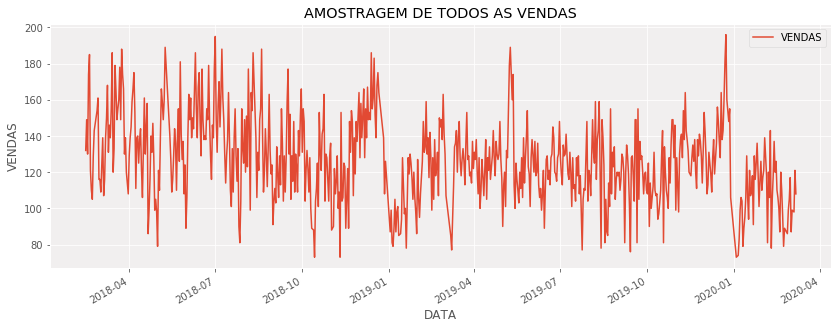

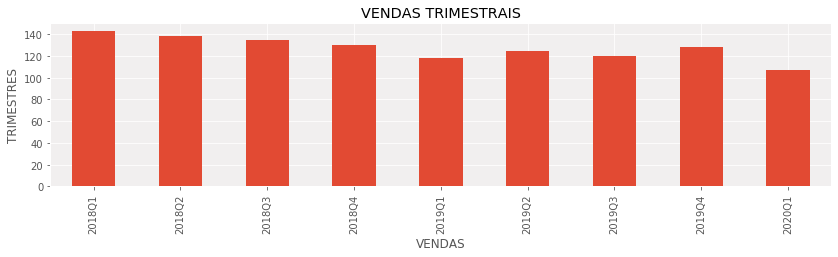

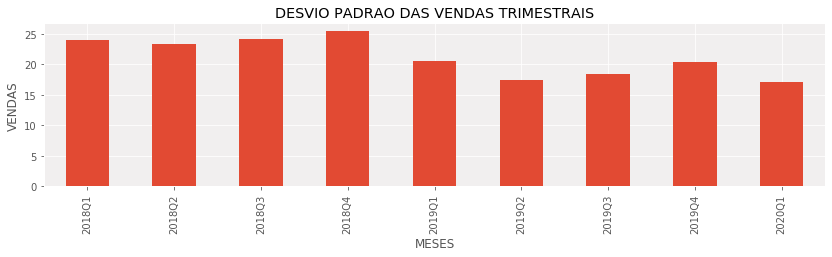

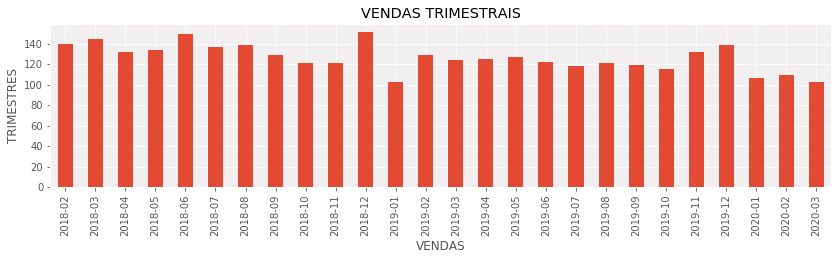

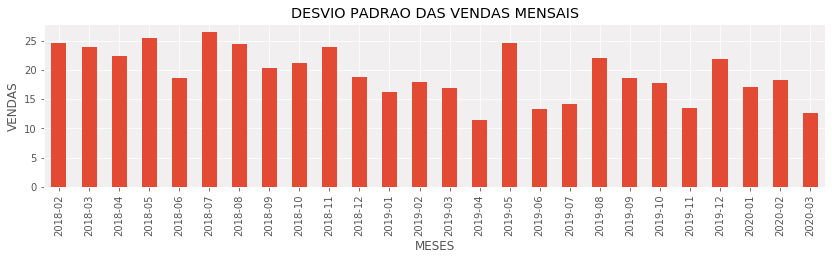

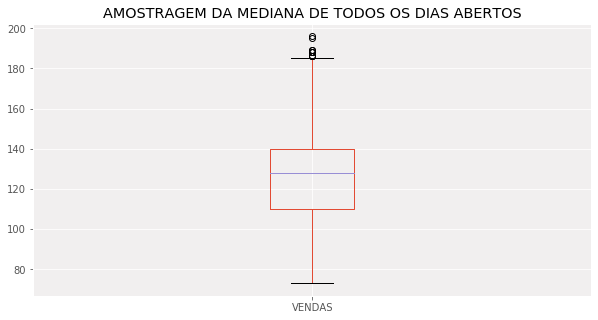

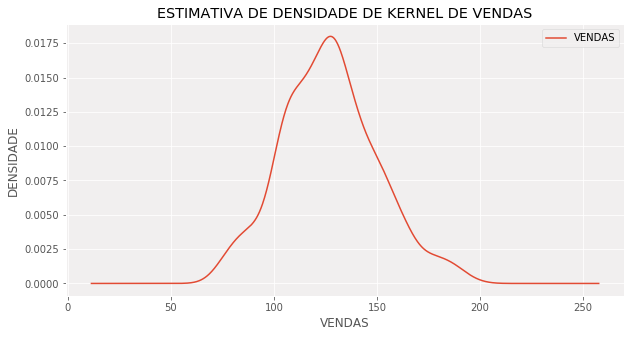

In [134]:
################################################ Periods and General Vision EDA
import matplotlib.pyplot as plt
import seaborn as sns

ax = df.plot(y=['VENDAS'], x='DATA', figsize=(14, 5))
plt.legend(loc=1)
plt.title('AMOSTRAGEM DE TODOS AS VENDAS')
plt.xlabel('DATA')
plt.ylabel('VENDAS')
plt.show()    

df_quarter = pd.DataFrame({'DATA': pd.to_datetime(df['DATA']), 'TEMPERATURA': df['TEMPERATURA'], 'VENDAS': df['VENDAS']})

df_quarter.groupby(df['DATA'].dt.to_period('Q'))['VENDAS'].agg('mean').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('VENDAS TRIMESTRAIS')
plt.xlabel('VENDAS')
plt.ylabel('TRIMESTRES')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('Q'))['VENDAS'].agg('std').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('DESVIO PADRAO DAS VENDAS TRIMESTRAIS')
plt.xlabel('MESES')
plt.ylabel('VENDAS')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('M'))['VENDAS'].agg('mean').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('VENDAS TRIMESTRAIS')
plt.xlabel('VENDAS')
plt.ylabel('TRIMESTRES')
plt.show()

df_quarter.groupby(df['DATA'].dt.to_period('M'))['VENDAS'].agg('std').plot(y='VENDAS', x='DATA', kind='bar', figsize=(14, 3))
plt.title('DESVIO PADRAO DAS VENDAS MENSAIS')
plt.xlabel('MESES')
plt.ylabel('VENDAS')
plt.show()

df.plot(y='VENDAS', x='DATA', figsize=(10, 5), kind='box')
plt.title('AMOSTRAGEM DA MEDIANA DE TODOS OS DIAS ABERTOS')
plt.show()

df.plot(y='VENDAS', x='DATA', figsize=(10, 5), kind='kde')
plt.legend(loc=1)
plt.title('ESTIMATIVA DE DENSIDADE DE KERNEL DE VENDAS')
plt.xlabel('VENDAS')
plt.ylabel('DENSIDADE')
plt.show()

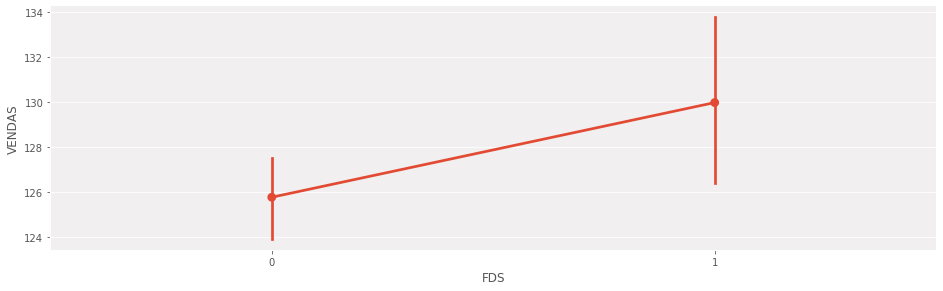

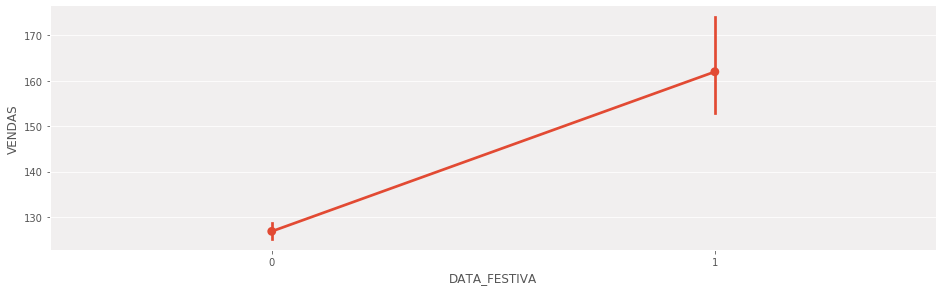

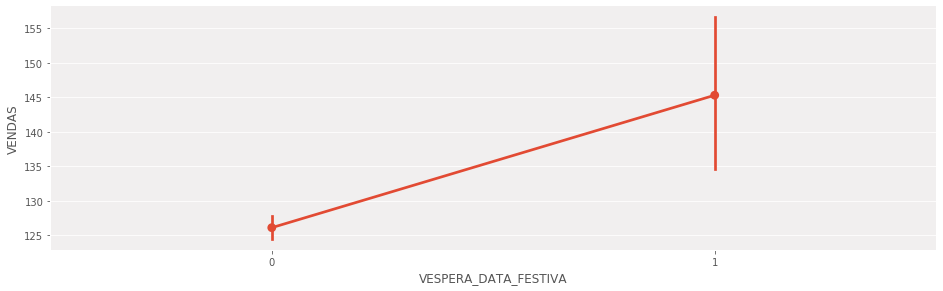

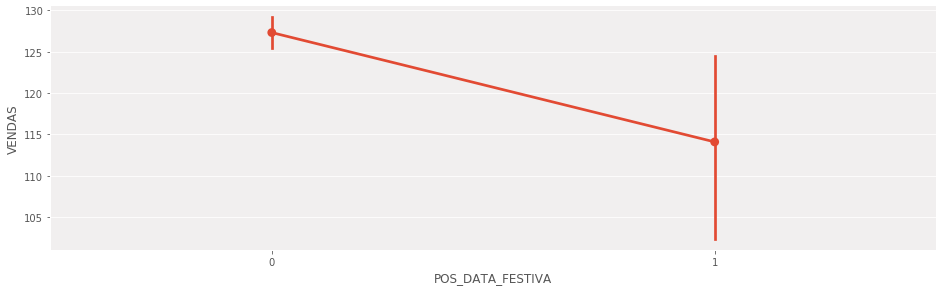

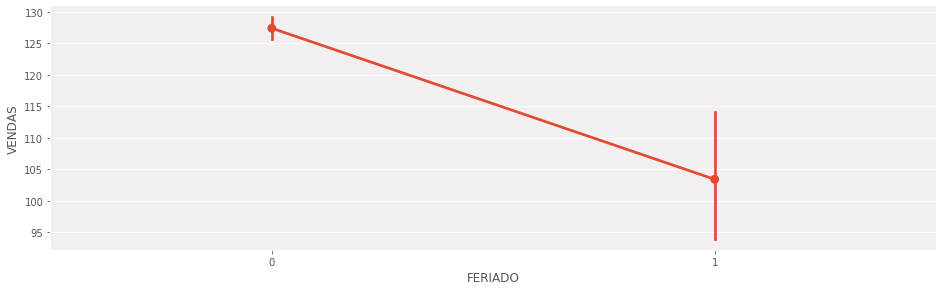

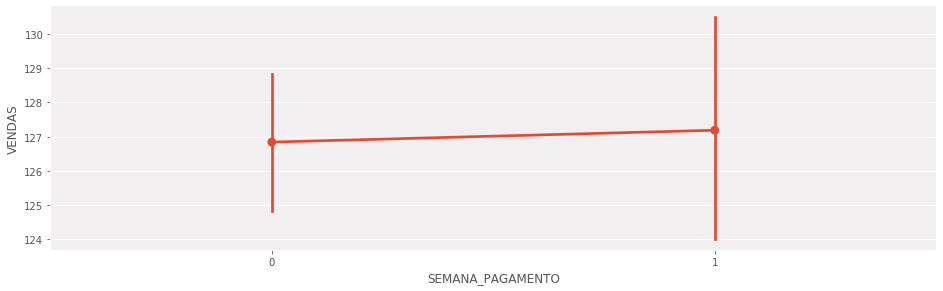

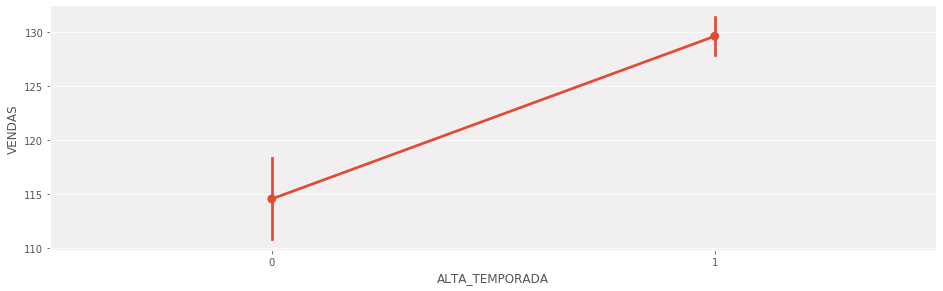

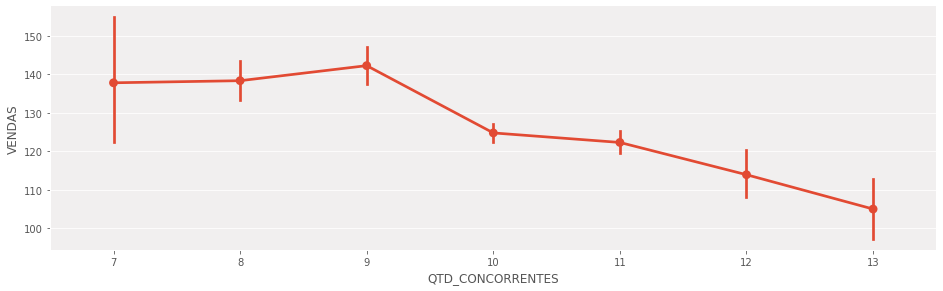

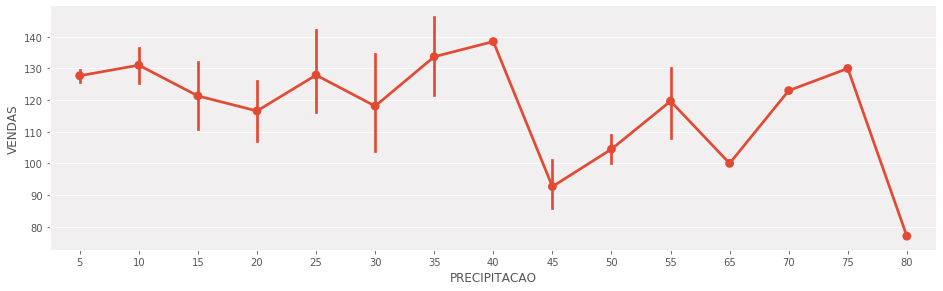

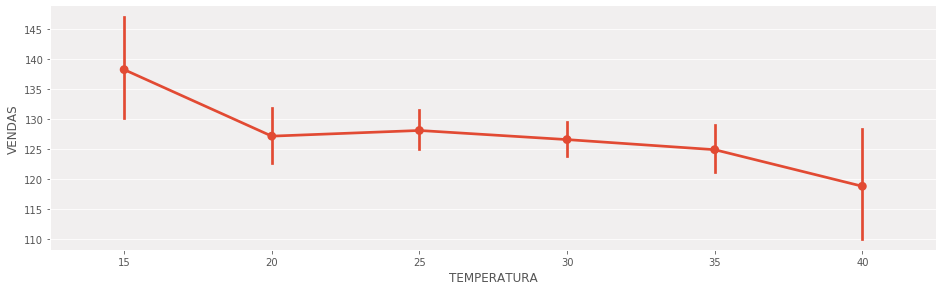

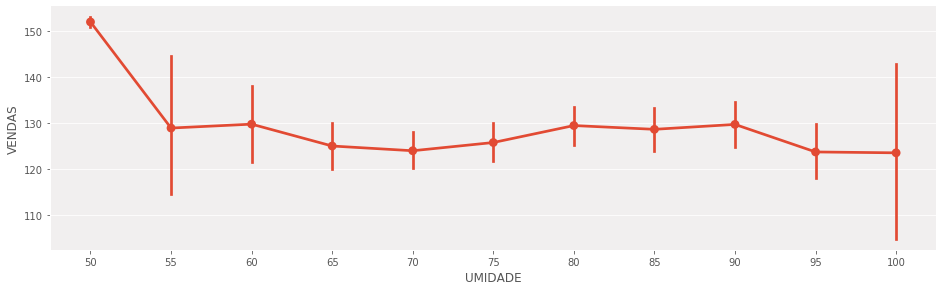

In [135]:
################################################ Columns EDA

df_scatter = df.sort_values(by=['VENDAS'], ascending=True)

c = sns.catplot('FDS', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('VESPERA_DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('POS_DATA_FESTIVA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('FERIADO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('SEMANA_PAGAMENTO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('ALTA_TEMPORADA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('QTD_CONCORRENTES', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('PRECIPITACAO', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('TEMPERATURA', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

c = sns.catplot('UMIDADE', 'VENDAS', data=df_scatter, kind='point')
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

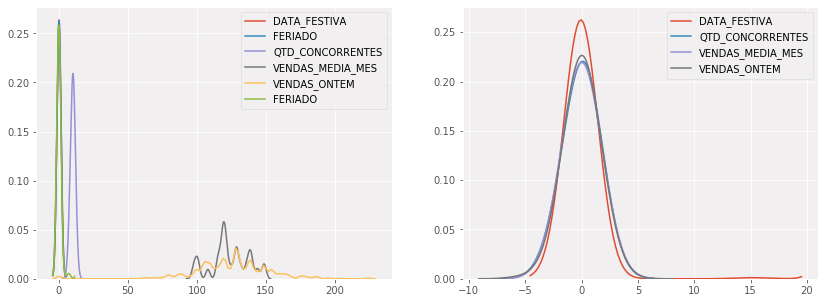

In [136]:
################################################ featured engineering
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import math
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt

import eli5
from eli5.sklearn import PermutationImportance
from sklearn import metrics
from sklearn.model_selection import cross_val_score, cross_val_predict

# droping columns that are not usefull according to the feature importance
# X = df.drop(columns=['DATA', 'VENDAS', 'SEMANA_PAGAMENTO', 'PRECIPITACAO', 'UMIDADE', 'TEMPERATURA', 'POS_DATA_FESTIVA', 'FDS', 'VESPERA_DATA_FESTIVA', 'ALTA_TEMPORADA', 'VENDAS_MEDIA_TRIM', 'VENDAS_STD_MES', 'VENDAS_STD_TRIM'])
X = df.drop(columns=['DATA', 'VENDAS', 'SEMANA_PAGAMENTO', 'PRECIPITACAO', 'UMIDADE', 'TEMPERATURA', 'POS_DATA_FESTIVA', 'FDS', 'VESPERA_DATA_FESTIVA', 'ALTA_TEMPORADA', 'VENDAS_MEDIA_TRIM', 'VENDAS_STD_MES', 'VENDAS_STD_TRIM'])
y = df.drop(columns=['DATA', 'FDS', 'DATA_FESTIVA', 'VESPERA_DATA_FESTIVA', 'POS_DATA_FESTIVA', 'FERIADO', 
                     'SEMANA_PAGAMENTO',  'ALTA_TEMPORADA', 'QTD_CONCORRENTES', 'PRECIPITACAO', 
                     'TEMPERATURA', 'UMIDADE', 'VENDAS_MEDIA_TRIM', 'VENDAS_MEDIA_MES', 'VENDAS_STD_TRIM', 'VENDAS_STD_MES', 'VENDAS_ONTEM'])

# save features names
features = X.columns.values.tolist()

# shuffled and splitted into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=8, shuffle=False)
y_train = np.array(y_train)
y_test = np.array(y_test)

#feature scaling
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X = scaler.fit_transform(X)

# plot scaling
scaled_X_train = pd.DataFrame(X_train, columns=['DATA_FESTIVA', 'FERIADO', 'QTD_CONCORRENTES', 'VENDAS_MEDIA_MES', 'VENDAS_ONTEM'])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 5))
sns.kdeplot(df['DATA_FESTIVA'], bw=1.5, ax=ax1)
sns.kdeplot(df['FERIADO'], bw=1.5, ax=ax1)
sns.kdeplot(df['QTD_CONCORRENTES'], bw=1.5, ax=ax1)
sns.kdeplot(df['VENDAS_MEDIA_MES'], bw=1.5, ax=ax1)
sns.kdeplot(df['VENDAS_ONTEM'], bw=1.5, ax=ax1)
sns.kdeplot(scaled_X_train['DATA_FESTIVA'], bw=1.5, ax=ax2)
sns.kdeplot(scaled_X_train['FERIADO'], bw=1.5, ax=ax1)
sns.kdeplot(scaled_X_train['QTD_CONCORRENTES'], bw=1.5, ax=ax2)
sns.kdeplot(scaled_X_train['VENDAS_MEDIA_MES'], bw=1.5, ax=ax2)
sns.kdeplot(scaled_X_train['VENDAS_ONTEM'], bw=1.5, ax=ax2)
plt.show()

RMSE (cross validation): 18.07
MAE (cross validation): 13.76
RMSE: 17.48
MAE: 13.30
R2: -0.11


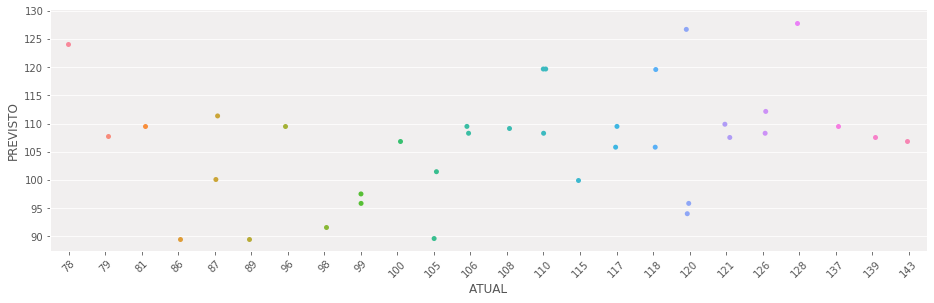

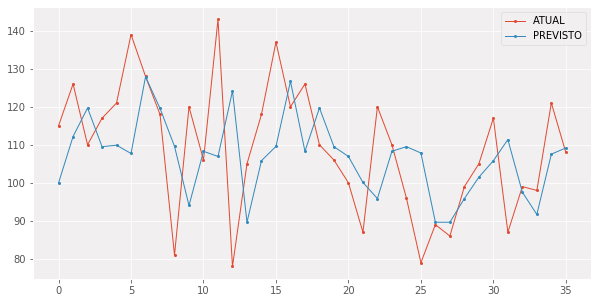

In [137]:
# imports
from sklearn.ensemble import GradientBoostingRegressor

# model
gb = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=25,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=21, min_samples_split=16,
                          min_weight_fraction_leaf=0.0, n_estimators=139,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=1, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

# cross validation
scores = cross_val_score(gb, X, y, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(gb, X, y, scoring='neg_mean_absolute_error', cv=5)
predicted = cross_val_predict(gb, X, y, cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

forecast_amount = int(math.ceil(0.01 * len(df)))

# manual training
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred))

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred.flatten(), 'ATUAL': y_test.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# plot
df1 = pd.DataFrame({'ATUAL': pd.DataFrame(y_test).values.flatten(), 'PREVISTO': y_pred.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

RMSE (cross validation): 17.08
MAE (cross validation): 13.44
RMSE: 17.34
MAE: 13.58
R2: -0.09


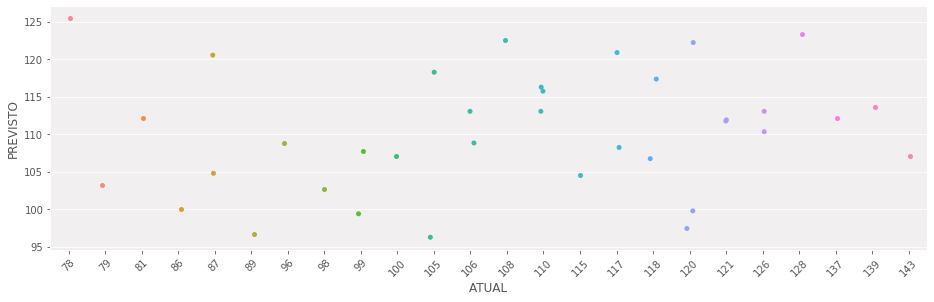

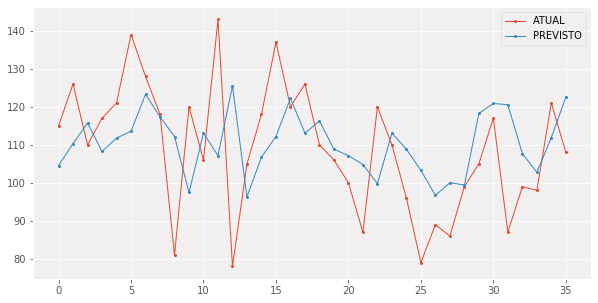

In [138]:
# imports 
from sklearn.neural_network import MLPRegressor

# model
nn = MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(730,), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=1, shuffle=False, solver='sgd',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

# cross validation
scores = cross_val_score(nn, X, y, scoring='neg_root_mean_squared_error', cv=5)
scores_mae = cross_val_score(nn, X, y, scoring='neg_mean_absolute_error', cv=5)
predicted = cross_val_predict(nn, X, y, cv=5)
print(f'RMSE (cross validation): %.2f' % np.abs(scores).min())
print(f'MAE (cross validation): %.2f' % np.abs(scores_mae).min())

# manual training
nn.fit(X_train, y_train)
y_pred = nn.predict(X_test)
print(f'RMSE: %.2f' % metrics.mean_squared_error(y_test, y_pred, squared=False))
print(f'MAE: %.2f' % metrics.mean_absolute_error(y_test, y_pred))
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred))

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred.flatten(), 'ATUAL': y_test.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)

# plot
df1 = pd.DataFrame({'ATUAL': pd.DataFrame(y_test).values.flatten(), 'PREVISTO': y_pred.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

RMSE: 16.39
MAE: 12.63
R2: 0.03


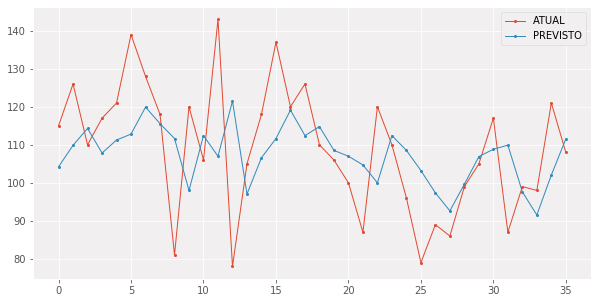

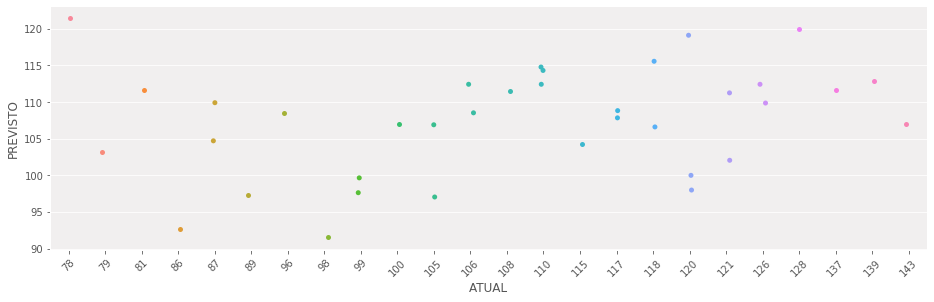

In [140]:
# imports
import seaborn as sns
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor

# reshape to 3D
train_X = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
train_y = y_train.reshape((y_train.shape[0], 1, y_train.shape[1]))
test_X = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
sizee = (int(train_X.shape[2] - 1) * -1)

# model
def base_model():
    lstm = Sequential()
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=True))
    lstm.add(Dropout(0.2))
    lstm.add(LSTM(190, return_sequences=False))
    lstm.add(Dropout(0.2))
    lstm.add(Dense(1))
    lstm.compile(loss='mean_squared_error', optimizer='adam')
    return lstm
lstm = KerasRegressor(build_fn=base_model)

# manual training
lstm.fit(train_X, train_y, epochs=200, batch_size=20, shuffle=False, verbose=False)
y_pred = lstm.predict(test_X)
y_pred = y_pred.reshape((y_pred.shape[0], 1))
test_X = test_X.reshape((test_X.shape[0], train_X.shape[2]))
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)
mae = metrics.mean_absolute_error(y_test, y_pred)
print(f'RMSE: %.2f' % rmse)
print(f'MAE: %.2f' % mae)
print(f'R2: %.2f' % metrics.r2_score(y_test, y_pred))

# plot
df1 = pd.DataFrame({'ATUAL': pd.DataFrame(y_test).values.flatten(), 'PREVISTO': y_pred.flatten()})
df1.plot(kind='line', figsize=(10, 5), linestyle='solid', linewidth=1, markersize=2, style="-o")
plt.show()

# scatter
c = sns.catplot('ATUAL', 'PREVISTO', data=pd.DataFrame({'PREVISTO': y_pred.flatten(), 'ATUAL': y_test.flatten() }))
c.set_xticklabels(rotation=45)
c.fig.set_figwidth(15)
c.fig.set_figheight(4)